<a href="https://colab.research.google.com/github/ach224/Prediction_eligibilite_pret_bancaire/blob/Modelisation_Aissatou/Projet_1_%E2%80%93_Pr%C3%A9diction_de_l%E2%80%99%C3%A9ligibilit%C3%A9_%C3%A0_un_pr%C3%AAt_bancaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Pour avoir la dataset automatiquement avec Kaggle API

In [105]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aissalamabarry","key":"870bd9d3bc7809081cd6cbdad4ec176b"}'}

In [106]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [107]:
!kaggle datasets download -d ninzaami/loan-predication

Dataset URL: https://www.kaggle.com/datasets/ninzaami/loan-predication
License(s): CC0-1.0
loan-predication.zip: Skipping, found more recently modified local copy (use --force to force download)


In [108]:
!unzip loan-predication.zip

Archive:  loan-predication.zip
  inflating: train_u6lujuX_CVtuZ9i (1).csv  


In [109]:
!mv "train_u6lujuX_CVtuZ9i (1).csv" train.csv

# Projet Prédiction Éligibilité Prêt
Objectif : prédire si un client est éligible à un prêt bancaire.


# 1 - Import des librairies

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2 - Chargement du dataset

In [111]:
# Charger les données
df = pd.read_csv("train.csv")


| Nom de la colonne   | Signification en français                          |
| ------------------- | -------------------------------------------------- |
| `Loan_ID`           | Identifiant du prêt                                |
| `Gender`            | Sexe du demandeur (Male/Female)                    |
| `Married`           | Marié(e) ou non (Yes/No)                           |
| `Dependents`        | Nombre de personnes à charge                       |
| `Education`         | Niveau d’éducation (Graduate/Not Graduate)         |
| `Self_Employed`     | Travailleur indépendant (Yes/No)                   |
| `ApplicantIncome`   | Revenu du demandeur principal                      |
| `CoapplicantIncome` | Revenu du co-demandeur (s’il y a un co-emprunteur) |
| `LoanAmount`        | Montant du prêt demandé (en milliers)              |
| `Loan_Amount_Term`  | Durée du prêt (en mois)                            |
| `Credit_History`    | Historique de crédit (1 = bon, 0 = mauvais)        |
| `Property_Area`     | Zone de résidence (Urban / Semiurban / Rural)      |
| `Loan_Status`       | Statut du prêt (Y = accordé / N = refusé)          |


In [112]:
# Voir en-têtes
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# 3 - Exploration initiale

In [113]:
# Informations générales
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [114]:
# Valeurs manquantes
df.isna().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [115]:
# Vérifier doublons
df.duplicated().sum()

np.int64(0)

### Remarque sur le dataset

- Le dataset contient **614 clients** et **13 colonnes(variables)**.  

- Certaines colonnes importantes présentent des **valeurs manquantes**, notamment :
  - `Gender` (13 valeurs manquantes)  
  - `Married` (3 valeurs manquantes)  
  - `Dependents` (15 valeurs manquantes)  
  - `Self_Employed` (32 valeurs manquantes)  
  - `LoanAmount` (22 valeurs manquantes)  
  - `Loan_Amount_Term` (14 valeurs manquantes)  
  - `Credit_History` (50 valeurs manquantes)  

> Ces valeurs manquantes devront être traitées avant la modélisation pour éviter les erreurs et pour que le modèle apprenne correctement.  

- le total des doublons est 0, donc il n’y a pas de doublons dans le dataset.

- La colonne `Loan_ID` est un identifiant unique et **ne sera pas utilisée** pour la prédiction, car il ne contient aucune information sur le client ou son éligibilité, il n’apporte rien au modèle.

- Les variables catégorielles (`Gender`, `Married`, `Education`, `Self_Employed`, `Property_Area`) devront être **encodées** pour être utilisées car les modèles de machine learning (Logistic Regression, Random Forest, Gradient Boosting…) ne comprennent que des nombres, donc il faut transformer ces textes en nombres.  

- La variable cible `Loan_Status` est complète, mais il faudra vérifier **l'équilibre des classes** (Y/N) pour savoir si un traitement du déséquilibre est nécessaire.

*Pourquoi vérifier l’équilibre des classes ?*

- Si le nombre de prêts accordés (Y) est beaucoup plus élevé que le nombre de refus (N), le dataset est déséquilibré.

    Exemple : 90% de Y (Oui) et 10% de N (Non) → le modèle pourrait juste prédire Y tout le temps et avoir une fausse impression de performance.


#4 - Traitement des valeurs manquantes


In [116]:
# Colonnes numériques : remplacer par la médiane
for col in ['LoanAmount', 'Loan_Amount_Term']:
    df[col] = df[col].fillna(df[col].median())

In [117]:
# Colonnes categorielle : remplacer par le mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    df[col] = df[col].fillna(df[col].mode()[0])


La méthode .fillna() en pandas sert à remplir les valeurs manquantes (NaN) dans un DataFrame ou une colonne.

In [118]:
#test
df.isna().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [119]:
# Suppression de la colonne Loan_ID
df.drop('Loan_ID', axis=1, inplace=True)

# Vérification
df.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Traitement des valeurs manquantes

- **Colonnes numériques** : `LoanAmount`, `Loan_Amount_Term`  
  - Nous avons choisi de **remplir les valeurs manquantes avec la médiane** de chaque colonne.  
  - **Justification** : la médiane est moins sensible aux valeurs extrêmes (outliers) que la moyenne et représente mieux le “client typique”. Par exemple, un prêt très élevé n’influencera pas la valeur utilisée pour remplir les manquants.  

- **Colonnes catégorielles** : `Gender`, `Married`, `Dependents`, `Self_Employed`, `Credit_History`  
  - Nous avons choisi de **remplir les valeurs manquantes avec la valeur la plus fréquente (mode)** de chaque colonne.  
  - **Justification** : cela permet de conserver la distribution originale des catégories et de remplir les données manquantes avec la valeur la plus probable pour ces clients, sans introduire de bruit artificiel.  

- **Colonnes très peu utiles ou identifiants** : `Loan_ID`  
  - Cette colonne ne contient aucune information sur l’éligibilité du prêt.  
  - Elle sera **supprimée** car elle n’apporte rien au modèle et pourrait biaiser la prédiction.  

> Ces choix sont des pratiques standards pour un **nettoyage initial des données** avant l’encodage et la modélisation. Ils permettent de préparer le dataset pour que les modèles de machine learning puissent apprendre correctement.


# 5 - Encodage des variables categorielles et cible

In [120]:
# Colonnes catégorielles à encoder
cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# One-Hot Encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Vérification
df.head()


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0.0,128.0,360.0,1.0,Y,True,False,False,False,False,True
1,1,4583,1508.0,128.0,360.0,1.0,N,True,True,False,False,False,False
2,0,3000,0.0,66.0,360.0,1.0,Y,True,True,False,True,False,True
3,0,2583,2358.0,120.0,360.0,1.0,Y,True,True,True,False,False,True
4,0,6000,0.0,141.0,360.0,1.0,Y,True,False,False,False,False,True


In [121]:
# Convertir la variable df['Dependents'] en int
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)
df['CoapplicantIncome'] = df['CoapplicantIncome'].astype(int)
df['LoanAmount'] = df['LoanAmount'].astype(int)
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(int)
df['Credit_History'] = df['Credit_History'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Dependents               614 non-null    int64 
 1   ApplicantIncome          614 non-null    int64 
 2   CoapplicantIncome        614 non-null    int64 
 3   LoanAmount               614 non-null    int64 
 4   Loan_Amount_Term         614 non-null    int64 
 5   Credit_History           614 non-null    int64 
 6   Loan_Status              614 non-null    object
 7   Gender_Male              614 non-null    bool  
 8   Married_Yes              614 non-null    bool  
 9   Education_Not Graduate   614 non-null    bool  
 10  Self_Employed_Yes        614 non-null    bool  
 11  Property_Area_Semiurban  614 non-null    bool  
 12  Property_Area_Urban      614 non-null    bool  
dtypes: bool(6), int64(6), object(1)
memory usage: 37.3+ KB


In [122]:
# Encoder Loan_Status
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Vérification
df['Loan_Status'].value_counts()

,count
Loan_Status,
1,422
0,192


In [123]:
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0,128,360,1,1,True,False,False,False,False,True
1,1,4583,1508,128,360,1,0,True,True,False,False,False,False
2,0,3000,0,66,360,1,1,True,True,False,True,False,True
3,0,2583,2358,120,360,1,1,True,True,True,False,False,True
4,0,6000,0,141,360,1,1,True,False,False,False,False,True


## - Encodage des variables catégorielles

Les modèles de machine learning ne comprennent que des valeurs
numériques.

Nous avons donc transformé les colonnes catégorielles en nombres :
Gender, Married, Education, Self_Employed, Property_Area ont été encodées à l’aide de variables booléennes (True/False) grâce à pd.get_dummies().

Exemple : Property_Area (Urban, Semiurban, Rural) est devenue trois colonnes :
Property_Area_Urban, Property_Area_Semiurban, Property_Area_Rural.

Justification :

L’encodage **One-Hot** permet de conserver la signification de chaque catégorie sans introduire d’ordre artificiel.

Cela rend les variables directement utilisables par les modèles comme la régression logistique ou les arbres de décision.


## - Encodage de la variable cible Loan_Status

La variable cible Loan_Status a été encodée avec :
* Y → 1 (prêt accordé)
* N → 0 (prêt refusé)

Justification :

Cet encodage numérique est nécessaire pour la modélisation supervisée.

Le résultat permettra au modèle de prédire une probabilité comprise entre 0 et 1, correspondant au risque d’acceptation du prêt.


## - Vérification de l’équilibre des classes

Après encodage, la distribution de Loan_Status est la suivante :

* 68,7 % de prêts accordés (1)

* 31,3 % de prêts refusés (0)

Remarque : il existe donc un léger déséquilibre entre les classes.
Nous le prendrons en compte lors de la phase de modélisation (par exemple via class_weight ou la technique SMOTE).

# 6 - Normalisation / Standardisation des variables numériques

Pour le moment, aucune normalisation ou standardisation n’a été appliquée.
Cette étape dépend du type de modèle de machine learning choisi :

🔹 Nécessaire pour les modèles sensibles à l’échelle des données (Régression logistique, SVM, KNN, Réseaux de neurones).

🔹 Optionnelle pour les modèles basés sur les arbres (Arbre de décision, Random Forest, XGBoost), qui ne dépendent pas de l’échelle des variables.

Une normalisation (ou standardisation) pourra donc être réalisée plus tard, une fois le modèle de prédiction sélectionné.

# 7 - Visualiser la distribution des variables

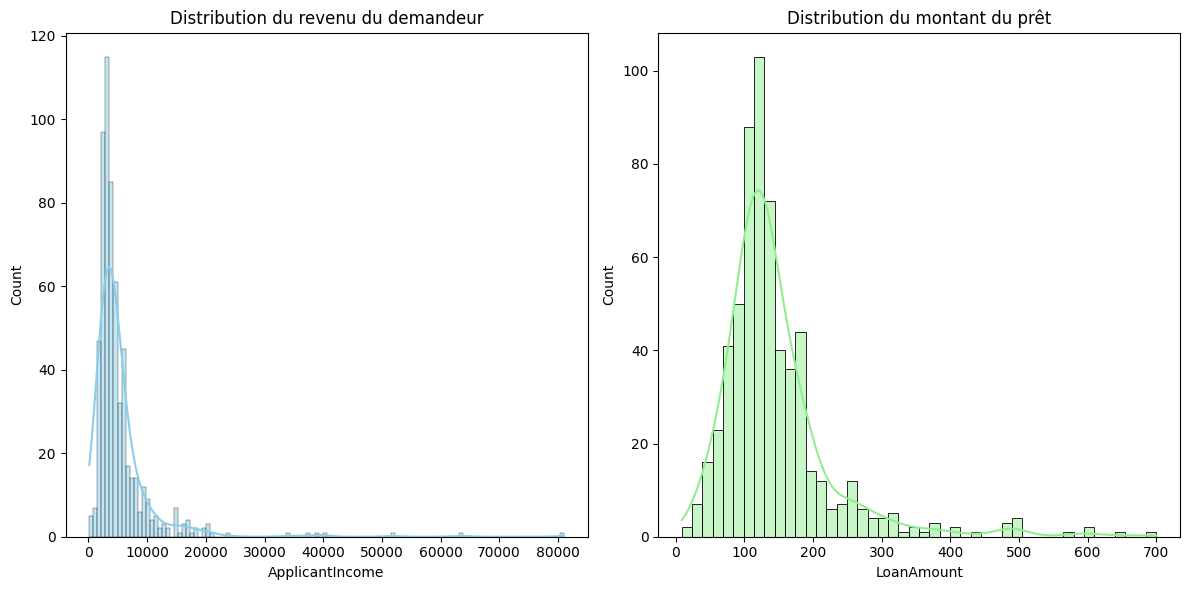

In [124]:
# Configuration des graphiques
plt.figure(figsize=(12,6))

# Distribution du revenu principal
plt.subplot(1, 2, 1)
sns.histplot(df['ApplicantIncome'], kde=True, color='skyblue')
plt.title('Distribution du revenu du demandeur')

# Distribution du montant du prêt
plt.subplot(1, 2, 2)
sns.histplot(df['LoanAmount'], kde=True, color='lightgreen')
plt.title('Distribution du montant du prêt')

plt.tight_layout()
plt.show()


À observer :

la distribution n'est pas symétrique, plus asymétrique vers la droite.

Avec des revenus ou montants très élevés (valeurs aberrantes).

# Rendre la distribution plus symétrique et diminuer l'impact des valeurs aberrantes




In [125]:
# Pour les revenus
df['ApplicantIncome'] = np.log1p(df['ApplicantIncome'])

# Pour le montant de prêt
df['LoanAmount'] = np.log1p(df['LoanAmount'])

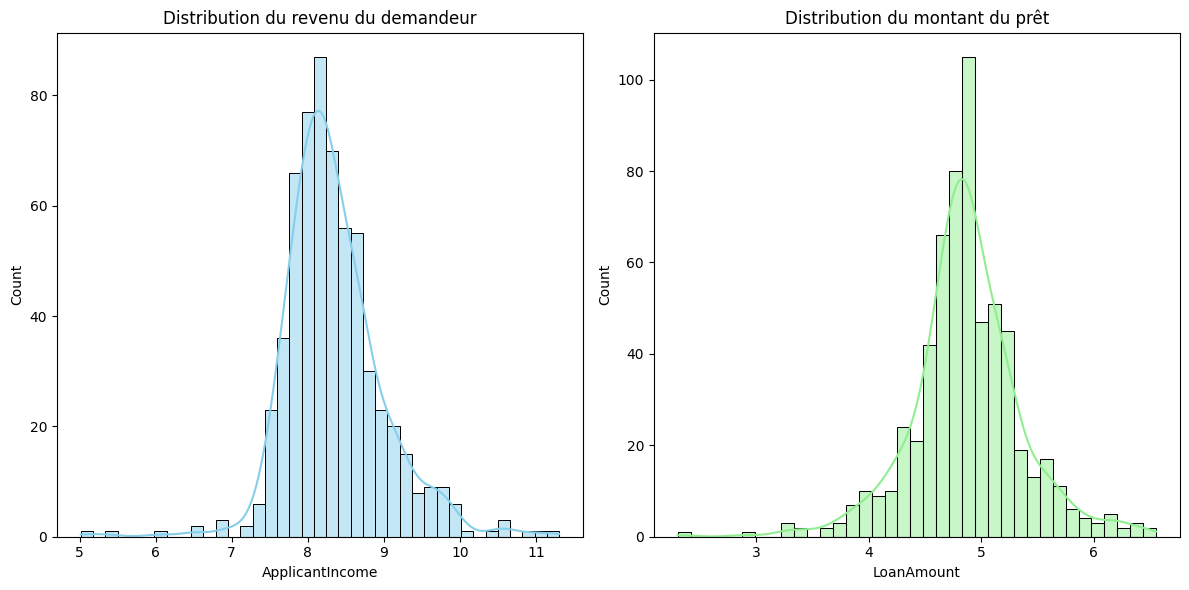

In [126]:
# Configuration des graphiques
plt.figure(figsize=(12,6))

# Distribution du revenu principal
plt.subplot(1, 2, 1)
sns.histplot(df['ApplicantIncome'], kde=True, color='skyblue')
plt.title('Distribution du revenu du demandeur')

# Distribution du montant du prêt
plt.subplot(1, 2, 2)
sns.histplot(df['LoanAmount'], kde=True, color='lightgreen')
plt.title('Distribution du montant du prêt')

plt.tight_layout()
plt.show()

Transformation logarithmique du revenu (ApplicantIncome)

Le revenu des demandeurs présente une forte asymétrie :
la majorité des clients ont un revenu faible à moyen, tandis qu’un petit nombre ont des revenus très élevés.

Ces valeurs extrêmes peuvent influencer les analyses et fausser certains modèles de machine learning.

Pour corriger cela, nous appliquons une transformation logarithmique.

Objectif

Rendre la distribution du revenu plus symétrique (plus proche d’une distribution normale).

Améliorer la lisibilité des visualisations (histogrammes, boxplots, etc.).

Faciliter la modélisation, notamment pour les algorithmes sensibles à la variance comme la régression linéaire ou logistique.

## Comparer les revenus entre éligibles et non éligibles
Objectif → voir si les revenus influencent la décision de prêt.

/tmp/ipython-input-938992204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df, palette='pastel')


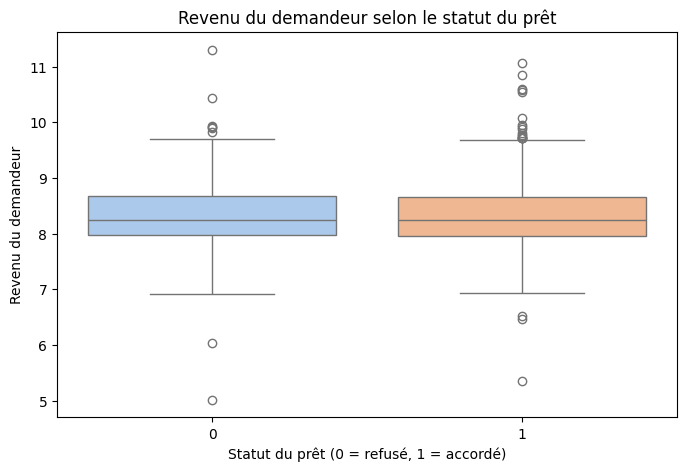

In [128]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df, palette='pastel')
plt.title("Revenu du demandeur selon le statut du prêt")
plt.xlabel("Statut du prêt (0 = refusé, 1 = accordé)")
plt.ylabel("Revenu du demandeur")
plt.show()


Médiane (ligne au milieu de la boîte) :

La médiane du revenu est presque la même pour les deux groupes → les personnes dont le prêt est accordé ou refusé gagnent en moyenne des revenus similaires.

Interprétation :

Le revenu n’est pas un critère suffisant pour prédire l’éligibilité au prêt.

Il pourrait toutefois interagir avec d’autres variables comme montant du prêt demandé, historique de crédit.

# 7 - Modélisation

1 - Définir la variable cible et les variables explicatives

In [129]:
# Variable cible (y)
y = df['Loan_Status']

# Variables explicatives (X)
X = df.drop('Loan_Status', axis=1)

#Dimension de X et y
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

X.head()


Shape de X: (614, 12)
Shape de y: (614,)


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,8.674197,0,4.859812,360,1,True,False,False,False,False,True
1,1,8.430327,1508,4.859812,360,1,True,True,False,False,False,False
2,0,8.006701,0,4.204693,360,1,True,True,False,True,False,True
3,0,7.857094,2358,4.795791,360,1,True,True,True,False,False,True
4,0,8.699681,0,4.955827,360,1,True,False,False,False,False,True


In [ ]:
X.head()

2 - Séparer le jeu de données en train et test

In [130]:
# Du module Scikitlearn importer la classe train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des dimensions
print("Dimension de X_train :", X_train.shape)
print("Dimension de y_train :", y_train.shape)
print("Dimension de X_test :", X_test.shape)
print("Dimension de y_test :", y_test.shape)

Dimension de X_train : (491, 12)
Dimension de y_train : (491,)
Dimension de X_test : (123, 12)
Dimension de y_test : (123,)


In [131]:
# Vérification de la répartition des 0/1 de la variable Loan_Status dans les deux groupes
print("Répartition dasn y_train :", y_train.value_counts(normalize=True))
print("\nRépartition dans y_test :", y_test.value_counts(normalize=True))

Répartition dasn y_train : Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64

Répartition dans y_test : Loan_Status
1    0.691057
0    0.308943
Name: proportion, dtype: float64


Lorsqu’on utilise train_test_split() pour diviser un jeu de données :


test_size = 0.2 → test_size(taille des données test) 20 % des données sont réservées pour le test et 80 % pour l’entraînement.


random_state = 42 → c'est une graine fixe qui garantit que la division des données sera la même à chaque exécution (reproductibilité) du code, car la separation des données se fait de manière aléatoire.


stratify=y → préserve la proportion des classes de la variable cible y(0,1) dans les deux ensembles (entraînement et test).

En résumé :

Ces paramètres assurent une répartition équilibrée, stable et représentative des données entre l’entraînement et le test.

3 - Normaliser / standardiser

Pour des modèles sensibles à l’échelle des variables (ex. régression logistique ou KNN).
Pour les arbres de décision et forêts aléatoires, ce n’est pas nécessaire.



In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


4 - Entraîner plusieurs modèles

🔹 Régression Logistique

In [133]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

🔹 Arbre de Décision

In [134]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

🔹 Forêt Aléatoire

In [135]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

🔹 Gradient Boosting

In [136]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

5 - Évaluer les performances

On évalue chaque modèle avec plusieurs métriques :  accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Évaluation des performances du modèle

### Calcul des métriques

#### Accuracy (Exactitude)
$$
\text{Accuracy} = \frac{TP + TN}{Total} = \frac{40 + 45}{100} = 0.85
$$
➡ **85 % des prédictions sont correctes.**

---

#### Precision (Précision)

$$
\text{Precision} = \frac{TP}{TP + FP} = \frac{40}{40 + 5} = 0.888
$$

➡ **Parmi les clients prédits éligibles, 88.8 % le sont vraiment.**

---

#### Recall (Rappel / Sensibilité)

$$
\mathrm{Recall} = \frac{TP}{TP + FN} = \frac{40}{40 + 10} = 0.8
$$

➡ **Le modèle détecte 80 % des clients réellement éligibles.**

---

#### F1 Score

$$
F_1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
= 2 \times \frac{0.888 \times 0.8}{0.888 + 0.8} \approx 0.842
$$

---



➡ **Bon compromis entre précision et rappel.**

---

#### ROC AUC

Représente la capacité du modèle à **séparer les classes** pour tous les seuils possibles.

- Valeur **0.5 → hasard**,  
- Valeur **1 → modèle parfait**.

Dans cet exemple, la **courbe ROC** aurait une **AUC ≈ 0.90**, ce qui indique une excellente capacité de discrimination.

---

### Interprétation générale

| Métrique | Signification | Objectif |
|-----------|----------------|-----------|
| **Accuracy** | Pourcentage global de bonnes prédictions | Élevé (sauf si classes déséquilibrées) |
| **Precision** | Fiabilité des positifs prédits | Élevée si l’on veut éviter les faux positifs |
| **Recall** | Capacité à détecter tous les vrais positifs | Élevée si l’on veut éviter les faux négatifs |
| **F1 Score** | Compromis entre précision et rappel | Utile quand les classes sont déséquilibrées |
| **ROC AUC** | Mesure globale de la capacité de séparation | Proche de 1 = très bon modèle |

---

 **Rappel visuel :**
- **TP (True Positive)** → Prédit positif, réellement positif  
- **TN (True Negative)** → Prédit négatif, réellement négatif  
- **FP (False Positive)** → Prédit positif, mais faux  
- **FN (False Negative)** → Prédit négatif, mais vrai


## Évaluation des modèles et choix des métriques

### Objectif du projet
L’objectif de ce projet est de prédire l’éligibilité d’un client à un prêt bancaire à partir de ses caractéristiques personnelles et financières.  
Il s’agit donc d’un **problème de classification binaire** où les classes sont :

- **1 : Client éligible**
- **0 : Client non éligible**

---

### Pourquoi évaluer plusieurs métriques ?
Aucune métrique seule ne suffit à juger la performance d’un modèle de classification.  
Chaque indicateur met en évidence un aspect différent de la performance.  

---

### Justification du choix des métriques dans ce projet
Dans le contexte de prédiction d’éligibilité à un prêt, il est **plus risqué de prédire à tort qu’un client est éligible (faux positif)**, car cela peut entraîner une **perte financière** pour l’établissement.  

Ainsi, nous accordons une importance particulière à :
- **La précision (Precision)** → pour éviter d’accorder un prêt à un client non solvable.  
- **Le F1-score** → pour maintenir un bon équilibre entre précision et rappel.  
- **Le ROC-AUC** → pour comparer globalement la capacité discriminante des modèles.

Le **rappel (Recall)** reste néanmoins utile pour s’assurer que le modèle ne rejette pas trop de bons clients.

---

### En pratique
Après l’entraînement, les métriques suivantes ont été calculées pour chaque modèle :
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **ROC-AUC**

Ces résultats, associés à la **matrice de confusion** et à la **courbe ROC**, ont permis de sélectionner le modèle offrant le meilleur compromis entre performance globale et fiabilité dans la détection des clients éligibles.

---
**Conclusion :**
Le choix des métriques n’est pas arbitraire ; il dépend directement du **contexte métier et du risque associé aux erreurs de classification**.  
Dans ce projet, la **précision** et le **F1-score** ont été privilégiés pour garantir des décisions fiables tout en maintenant une bonne couverture des clients réellement éligibles.



Logistic Regression

Matrice de confusion :


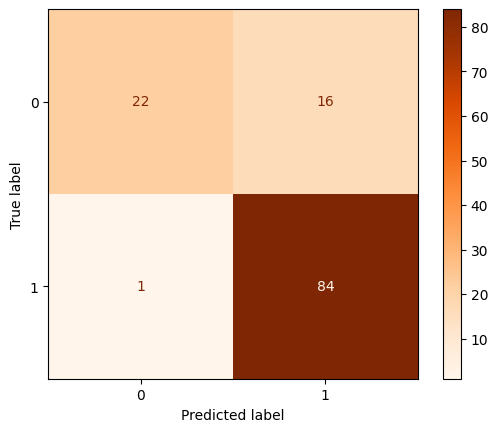

Accuracy: 0.862
Precision: 0.84
Recall: 0.988
F1 Score: 0.908

Decision Tree

Matrice de confusion :


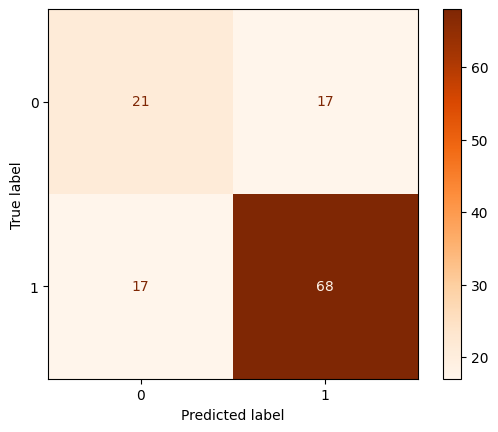

Accuracy: 0.724
Precision: 0.8
Recall: 0.8
F1 Score: 0.8

Random Forest

Matrice de confusion :


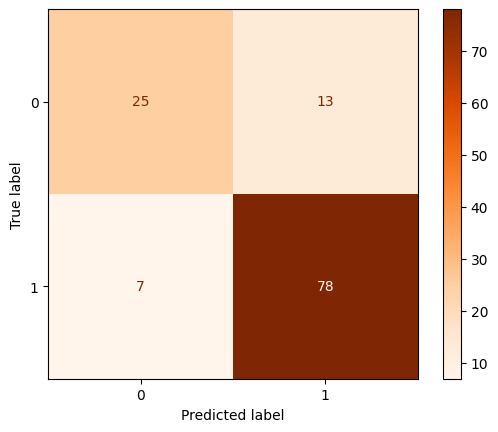

Accuracy: 0.837
Precision: 0.857
Recall: 0.918
F1 Score: 0.886

Gradient Boosting

Matrice de confusion :


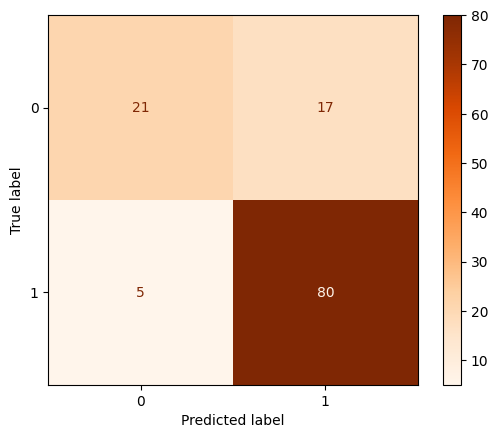

Accuracy: 0.821
Precision: 0.825
Recall: 0.941
F1 Score: 0.879


In [137]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay

models = {
    "Logistic Regression": logreg,
    "Decision Tree": tree,
    "Random Forest": rf,
    "Gradient Boosting": gb
}

for name, model in models.items():

    # Prédictions (classes)
    if name == "Logistic Regression":
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    # Matrice de confusion
    print(f"\n{name}")
    print("\nMatrice de confusion :")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Oranges)
    plt.show()

    # Metrics classiques
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("F1 Score:", round(f1_score(y_test, y_pred), 3))


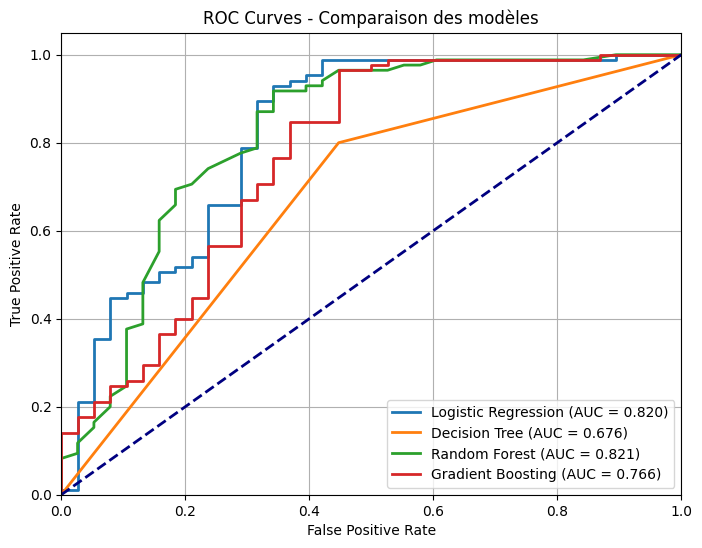

In [139]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, model in models.items():
    # Prédictions probabilistes pour la classe 1
    if name == "Logistic Regression":
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.predict_proba(X_test)[:, 1]

    # Calcul FPR, TPR et AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Tracer la diagonale
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Paramètres du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparaison des modèles')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
